## Data Analysis and Preparation

### Import libraries

In [1]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import yaml

# Load YAML configuration file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

### Configurations

In [3]:
PROJECT = config['project']
REGION = config['region']

BQ_DATASET_NAME = config['bq_dataset_name']
BQ_TABLE_NAME = config['bq_table_name']
BQ_LOCATION = config['bq_location']

DATASET_DISPLAY_NAME = config['dataset_display_name']

# RAW_SCHEMA_DIR = config['raw_schema_dir']

## EDA

In [4]:
%load_ext google.cloud.bigquery

In [6]:
# Run the BigQuery query
client = bigquery.Client()

query = """
SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A', CAST(trip_start_timestamp AS DATE)) AS trip_dayname,
    COUNT(*) AS trip_count
FROM `pa-poc-mlspec-1.chicago_taxi_trips.taxi_trips`
WHERE EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY trip_dayofweek, trip_dayname
ORDER BY trip_dayofweek
"""

# Run the query and convert to a pandas DataFrame
df = client.query(query).to_dataframe()


c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


<Axes: xlabel='trip_dayname'>

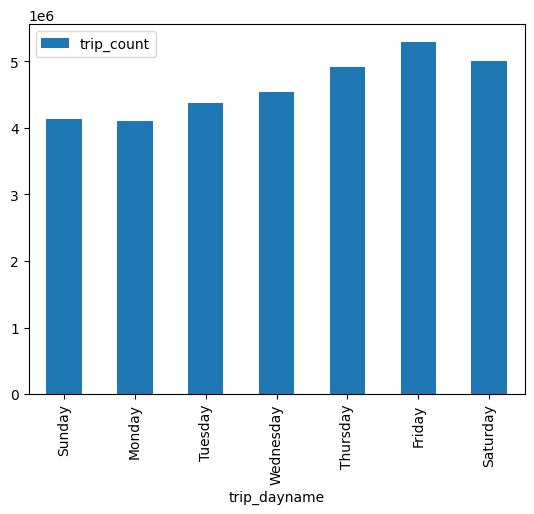

In [7]:
df.plot(kind='bar', x='trip_dayname', y='trip_count')

### Create destination BigQuery dataset

In [22]:
!bq --location=$BQ_LOCATION mk -d \
$PROJECT:$BQ_DATASET_NAME

BigQuery error in mk operation: Dataset 'pa-poc-mlspec-1:playground' already
exists.


In [23]:
sample_size = 1000000
year = 2020
sql_script = config["sql_script"]

In [24]:
sql_script = sql_script.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

In [25]:
bq_client = bigquery.Client(project=PROJECT, location=BQ_LOCATION)
job = bq_client.query(sql_script)
_ = job.result()

In [18]:
%%bigquery --project {PROJECT}

SELECT dropoff_community_area, community_name,
SUM(total_arrests) AS total_arrests
FROM playground.taxi_trips 
GROUP BY dropoff_community_area, community_name

Query is running:   0%|          |

c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

,dropoff_community_area,community_name,total_arrests
0,24,West Town,171118392
1,51,South Deering,2233401
2,76,O'Hare,30021435
3,28,Near West Side,746036100
4,33,Near South Side,47299142
...,...,...,...
73,57,Archer Heights,265490
74,45,Avalon Park,1297257
75,55,Hegewisch,80264
76,54,Riverdale,432822


### Load a sample data to a Pandas DataFrame

In [36]:
%%bigquery df --project {PROJECT}

SELECT * EXCEPT (trip_start_timestamp)
FROM playground.taxi_trips 

Query is running:   0%|          |

c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2309: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2323: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
c:\Users\MANSM\Demo\GCPML-ChicagoTaxi\.venv\lib\site-packages\google\cloud\bigquery\table.py:2337: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


Downloading:   0%|          |

In [37]:
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

community_name            1815
total_arrests             1815
pickup_community_area       26
dropoff_community_area    1815
dtype: int64


In [38]:
df = df.dropna()

In [39]:
df.head().T

,0,1,2,3,4
trip_month,1,1,2,2,1
trip_day,7,7,28,18,25
trip_day_of_week,3,3,6,3,7
trip_hour,19,19,15,10,23
trip_seconds,306,392,484,524,533
trip_miles,1.28,1.28,1.07,0.82,2.94
payment_type,Cash,Cash,Cash,Cash,Credit Card
pickup_grid,POINT(-87.7 42),POINT(-87.7 42),POINT(-87.7 42),POINT(-87.7 42),POINT(-87.7 41.9)
dropoff_grid,POINT(-87.7 42),POINT(-87.7 42),POINT(-87.6 41.9),POINT(-87.6 41.9),POINT(-87.7 41.9)
euclidean,1403.257682,1403.257682,13866.448558,14439.98956,3353.615288


<Axes: >

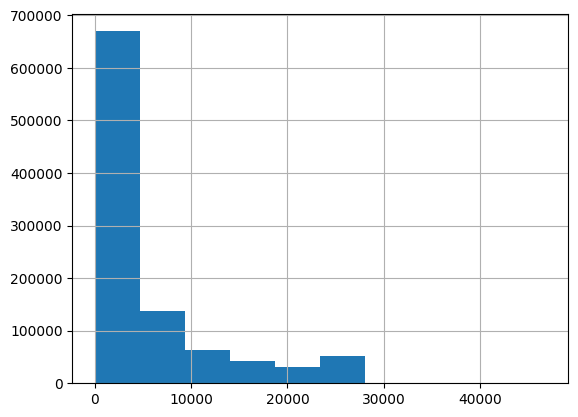

In [40]:
df.euclidean.hist()

In [41]:
df['tip_percentage'] = (df['tips'] / df['fare']) * 100

# Create a binary target variable: 1 if tips > 20%, 0 otherwise
df['high_tip'] = np.where(df['tip_percentage'] > 20, 1, 0)


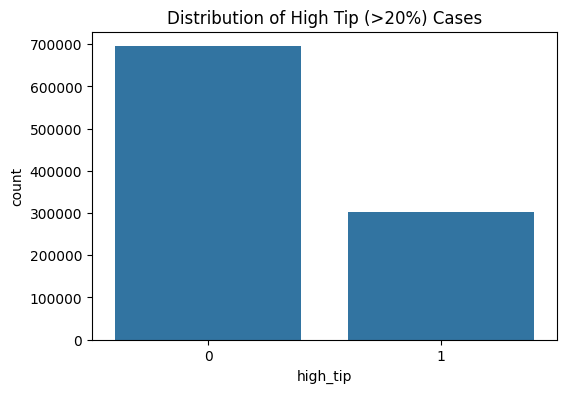

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='high_tip')
plt.title('Distribution of High Tip (>20%) Cases')
plt.show()


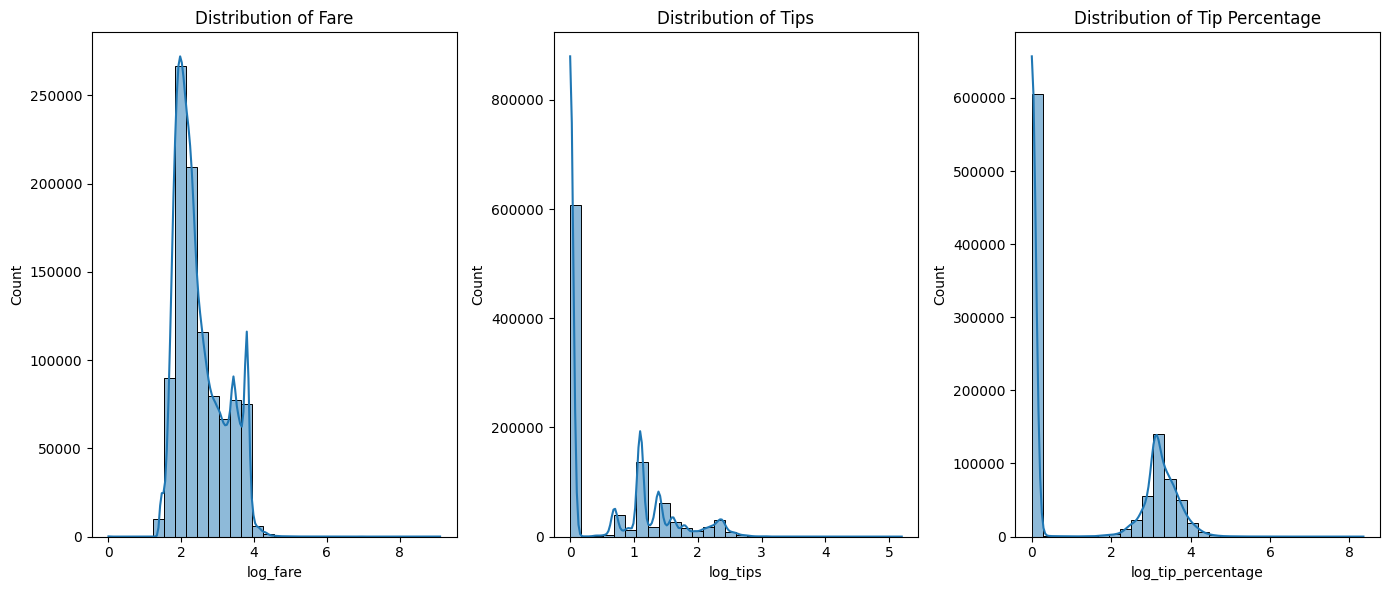

In [20]:
# Avoid taking log of zero or negative values by adding a small constant
df['log_fare'] = np.log1p(df['fare'])
df['log_tips'] = np.log1p(df['tips'])
df['log_tip_percentage'] = np.log1p(df['tip_percentage'])

plt.figure(figsize=(14, 6))

# Log-transformed Fare
plt.subplot(1, 3, 1)
sns.histplot(df['log_fare'], kde=True, bins=30)
plt.title('Distribution of Fare')

# Log-transformed Tips
plt.subplot(1, 3, 2)
sns.histplot(df['log_tips'], kde=True, bins=30)
plt.title('Distribution of Tips')

# Log-transformed Tip Percentage
plt.subplot(1, 3, 3)
sns.histplot(df['log_tip_percentage'], kde=True, bins=30)
plt.title('Distribution of Tip Percentage')

plt.tight_layout()
plt.show()


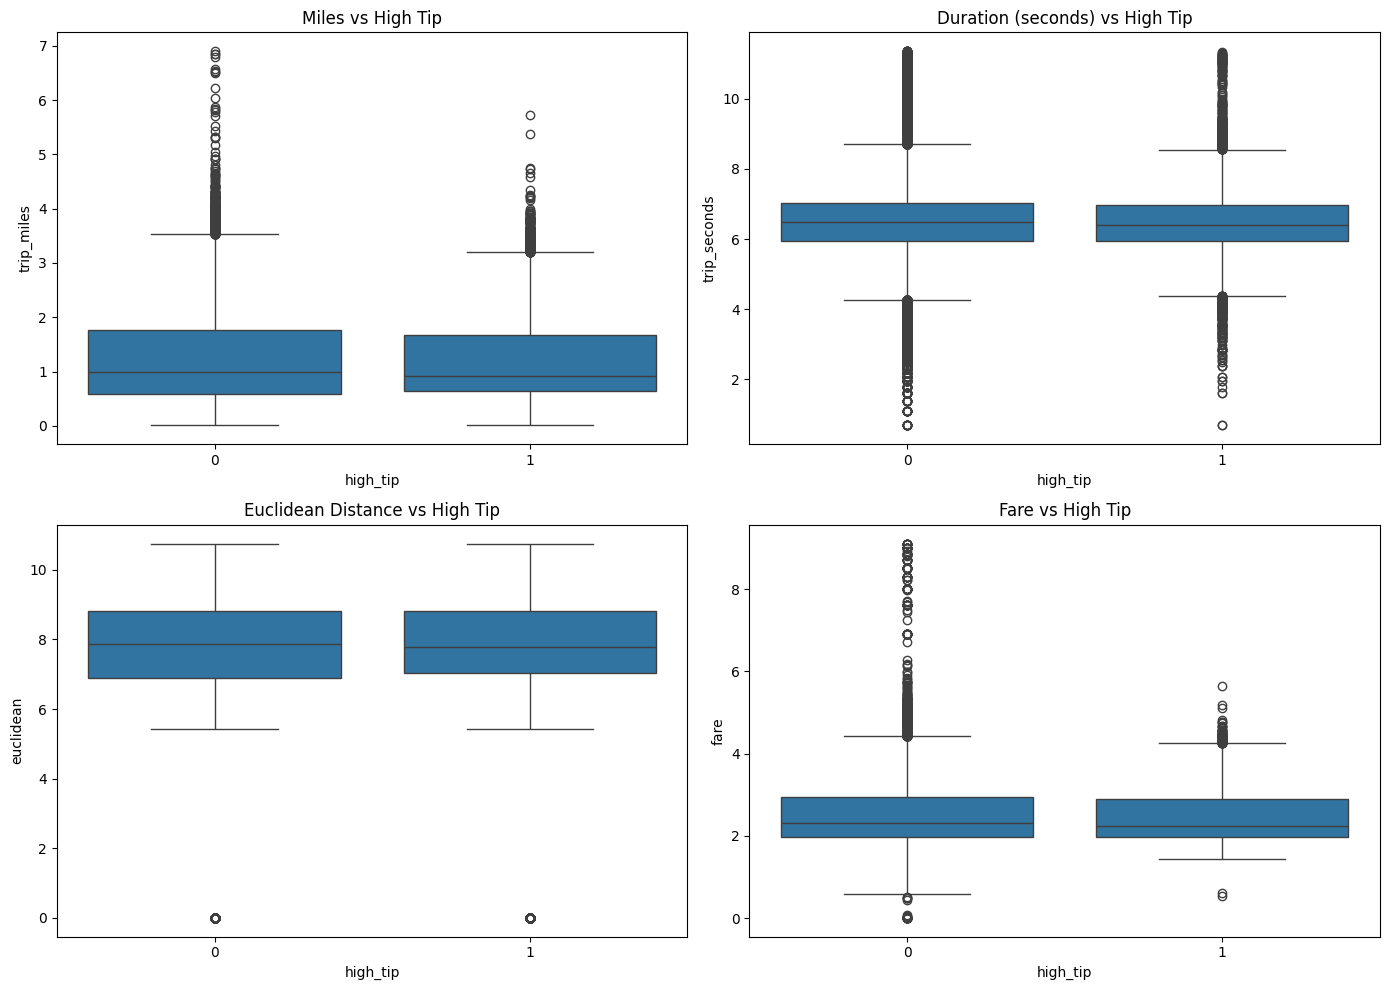

In [21]:
plt.figure(figsize=(14, 10))

# Log Trip Miles vs High Tip
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='high_tip', y=np.log1p(df['trip_miles']))
plt.title('Miles vs High Tip')

# Log Trip Duration (seconds) vs High Tip
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='high_tip', y=np.log1p(df['trip_seconds']))
plt.title('Duration (seconds) vs High Tip')

# Log Euclidean Distance vs High Tip
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='high_tip', y=np.log1p(df['euclidean']))
plt.title('Euclidean Distance vs High Tip')

# Log Fare vs High Tip
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='high_tip', y=np.log1p(df['fare']))
plt.title('Fare vs High Tip')

plt.tight_layout()
plt.show()


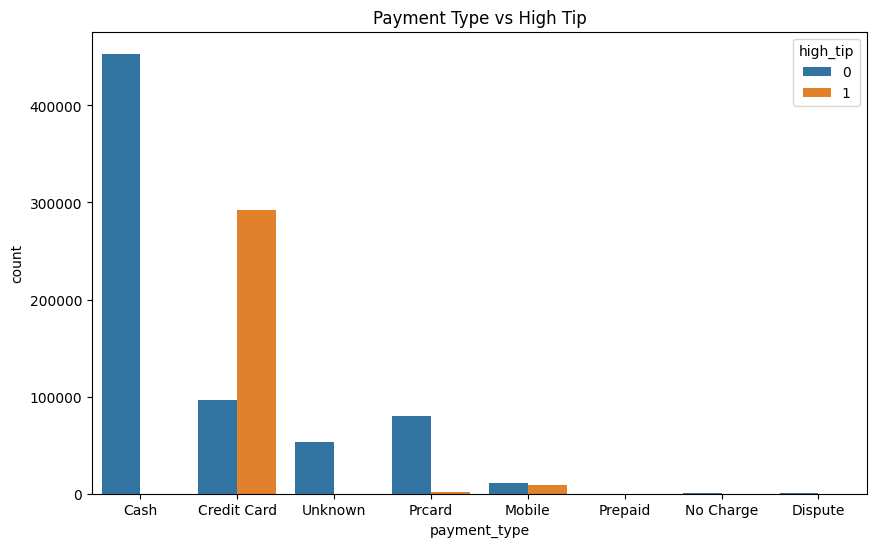

In [22]:
# Payment type vs High Tip
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='payment_type', hue='high_tip')
plt.title('Payment Type vs High Tip')
plt.show()

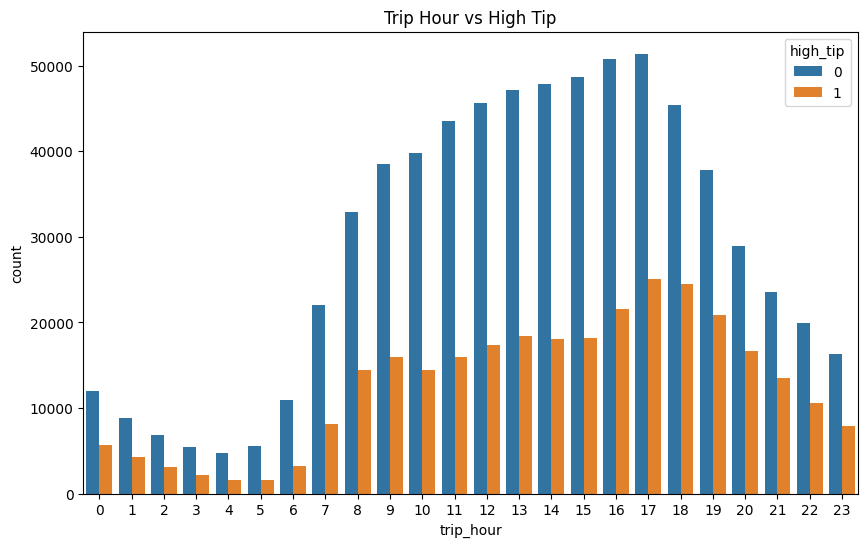

In [23]:
# Trip hour vs High Tip
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='trip_hour', hue='high_tip')
plt.title('Trip Hour vs High Tip')
plt.show()


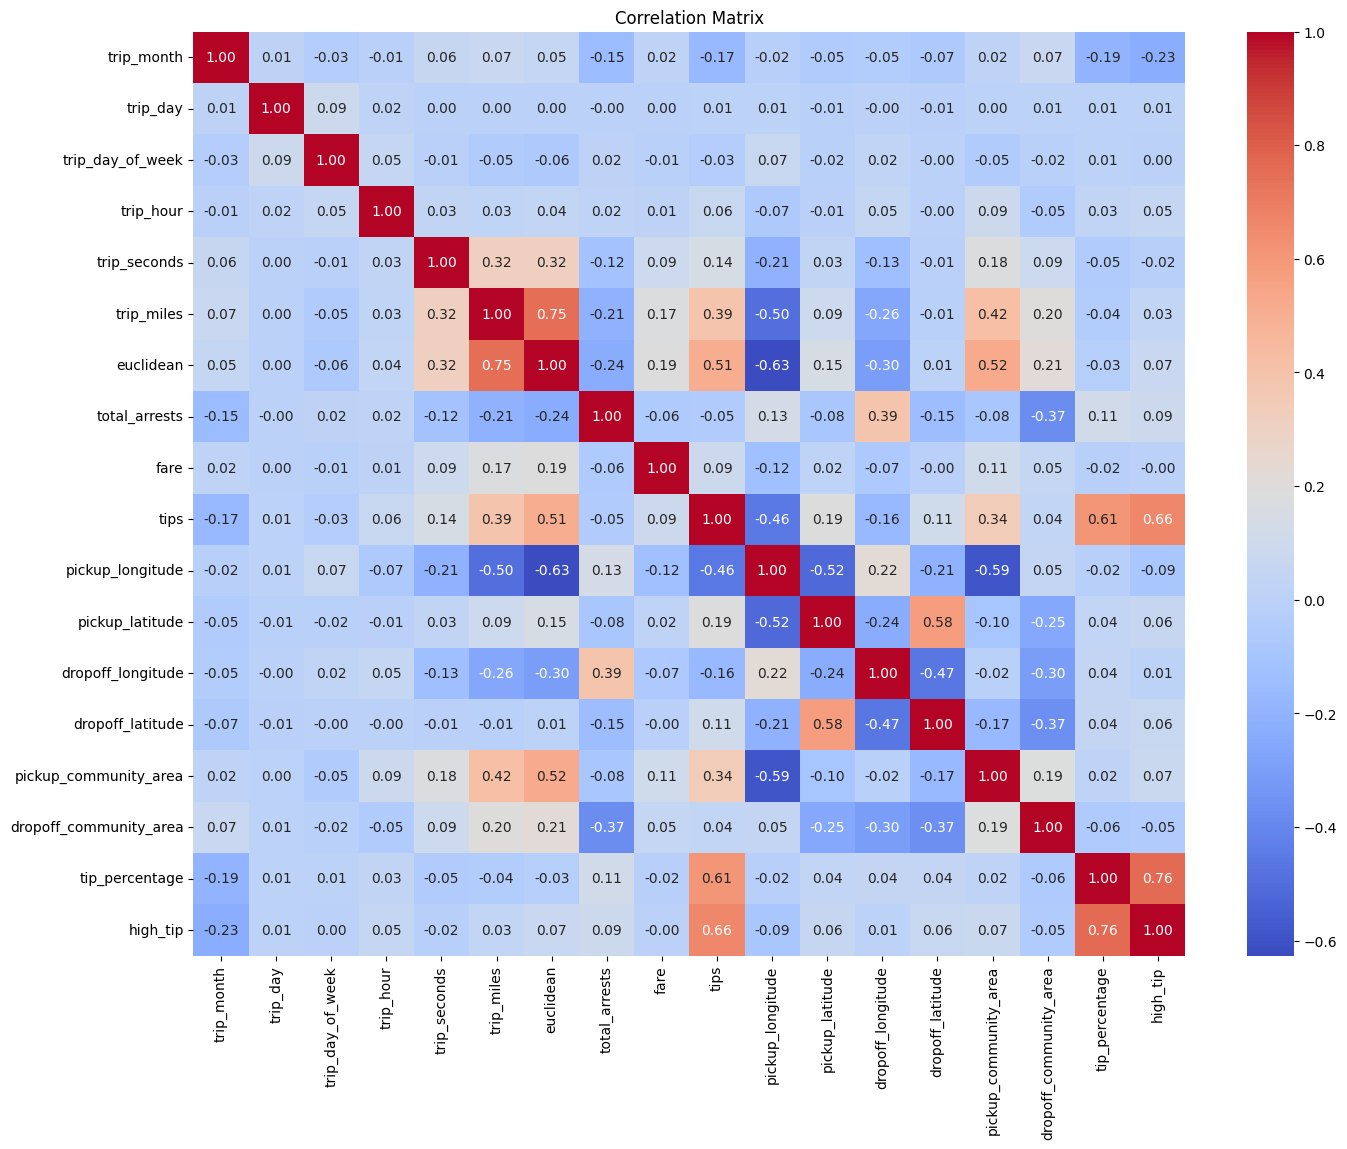

In [29]:
columns_to_include = [col for col in df.select_dtypes(include=[np.number]).columns if 'log' not in col]


df_numeric = df[columns_to_include].apply(pd.to_numeric, errors='coerce')

# Drop columns or rows that are entirely NaN
df_numeric = df_numeric.dropna(axis=1, how='all')  # Drop columns with all NaN
df_numeric = df_numeric.dropna(axis=0, how='any')  # Drop rows with any NaN

# Calculate the correlation matrix
corr_matrix = df_numeric.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

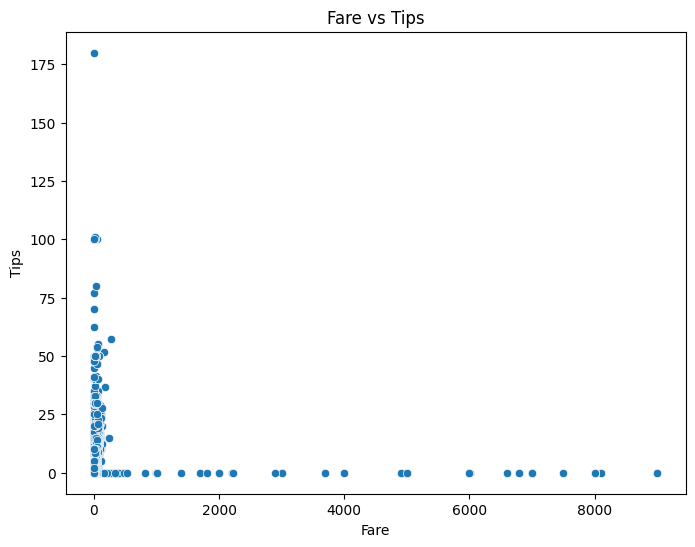

Percentage of tips > 20% of fare: 30.38%


In [30]:
_LABEL_KEY = 'tips'
_FARE_KEY = 'fare'

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df[_FARE_KEY], y=df[_LABEL_KEY])
plt.title(f'Fare vs Tips')
plt.xlabel('Fare')
plt.ylabel('Tips')
plt.show()

# Check percentage of tips > 20% of fare
df['tip_percentage'] = (df[_LABEL_KEY] / df[_FARE_KEY]) * 100
high_tippers = df[df['tip_percentage'] > 20]

print(f"Percentage of tips > 20% of fare: {len(high_tippers) / len(df) * 100:.2f}%")

# Feature Selection & Justification for Tip Prediction Model

---

## Selected Features

1. **Temporal Features**:
   - **`trip_month`, `trip_day`, `trip_day_of_week`, `trip_hour`**:
     - **Reason**: These features capture the time of the trip, allowing for analysis of tipping behavior based on time-related factors (e.g., weekend vs. weekday, rush hour vs. off-peak).

2. **Trip Characteristics**:
   - **`trip_seconds`, `trip_miles`, `euclidean`**:
     - **Reason**: These measure the trip's duration, distance, and directness, which can influence a rider's tipping decision based on the efficiency or length of the journey.

3. **Payment Type**:
   - **`payment_type`**:
     - **Reason**: Payment method (cash vs. card) can affect tipping behavior, as electronic payments often allow for easier and potentially larger tips.

4. **Area Safety Proxy**:
   - **`total_arrests`**:
     - **Reason**: High-crime areas might correlate with tipping behavior due to perceptions of safety or risk during the trip.

5. **Fare Information**:
   - **`fare`**:
     - **Reason**: Tips are usually based on a percentage of the fare, making this a critical feature for predicting tipping behavior.

6. **Geographic Information**:
   - **`pickup_community_area`, `dropoff_community_area`**:
     - **Reason**: These capture the socioeconomic context of pickup and dropoff locations, which may influence tipping based on location-specific tipping norms.

---

## Dropped Features

1. **Detailed Geographic Data**:
   - **`pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`**:
     - **Reason for Dropping**: Latitude and longitude are too granular, and community areas already capture geographic patterns. Including both would introduce redundancy without adding substantial value.

2. **Grid Information**:
   - **`pickup_grid`, `dropoff_grid`**:
     - **Reason for Dropping**: Similar to longitude/latitude, these features offer too much granularity. The community areas offer sufficient geographic context in a more interpretable format.

3. **Cross-Street Data**:
   - **`loc_cross`**:
     - **Reason for Dropping**: Cross-street information is overly specific and may not provide additional predictive value beyond the community area features.

4. **Community Names**:
   - **`community_name`**:
     - **Reason for Dropping**: Community names are less useful in a numerical model compared to the numeric community area codes, which are easier for the model to process and provide the same geographic information.

---

## Conclusion

- **Selected Features**: Focused on trip details, payment methods, time-based factors, and geographic locations.
- **Dropped Features**: Excluded overly granular or redundant columns that do not add significant predictive power.


In [42]:
df.columns

Index(['trip_month', 'trip_day', 'trip_day_of_week', 'trip_hour',
       'trip_seconds', 'trip_miles', 'payment_type', 'pickup_grid',
       'dropoff_grid', 'euclidean', 'loc_cross', 'community_name',
       'total_arrests', 'fare', 'tips', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_community_area',
       'dropoff_community_area', 'tip_percentage', 'high_tip'],
      dtype='object')

In [44]:
columns_to_drop = [
    'pickup_longitude', 
    'pickup_latitude', 
    'dropoff_longitude', 
    'dropoff_latitude', 
    'pickup_grid', 
    'dropoff_grid', 
    'loc_cross', 
    'community_name',
    "tip_percentage",
    "high_tip"
]

# Drop the specified columns
df = df.drop(columns=columns_to_drop)

In [47]:
df.to_csv("data/chicago_trips.csv", index=False)